<a href="https://colab.research.google.com/github/DavidPachis/dataScience/blob/main/taller4/notebook/Taller4CDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller 4**
>Julian Yamid Torres Torres jy.torres@uniandes.edu.co <br>


>MINE-4101: Ciencia de Dato Aplicada

>Univerisdad de los Andes

>Semestre: 2022-2

## IMPORTACIÓN DE LIBRERÍAS

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
#import keras_tuner as kt
import joblib as jbl
import warnings

warnings.filterwarnings("ignore")

from sklearn import tree

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Ridge, Lasso

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score , classification_report , ConfusionMatrixDisplay

In [ ]:
# Dataset de Entrenamiento
url = "https://raw.githubusercontent.com/JulianTorrest/MINE-Ciencia-de-datos-Aplicada/main/Taller4/data/DataSet_Entrenamiento_v1.json"
df = pd.read_json(url)

##Actividades

### Proceso de Limpieza

In [ ]:
def cleaning(dataset):
  # Limpiar TotalCharges con valor 0 
  dataset.loc[dataset["tenure"] == 0, "TotalCharges"] = "0"
  dataset['TotalCharges'].astype(float)
  # Asociar las columnas
  objetivo  = dataset["Churn"]
  numericas = dataset[["MonthlyCharges","tenure","SeniorCitizen","TotalCharges"]]
  gender = dataset["gender"]
  categoricas_1 = dataset[['Partner','PhoneService','PaperlessBilling','Dependents']]
  categoricas_2 = dataset[[
      "InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
      "StreamingTV","StreamingMovies","Contract","PaymentMethod"
      ]]
  excluidas = dataset[["customerID","MultipleLines"]]

  #Realizar la transformación
  objetivo = objetivo.replace(['No', 'Yes'],[0, 1])
  gender = gender.replace(['Female', 'Male'],[0, 1])
  categoricas_1 = categoricas_1.replace(['No', 'Yes'],[0, 1])
  categoricas_2 = pd.get_dummies(categoricas_2)
  numericas = numericas.astype(float)

  #Limpieza del dataset
  clean_dataset = pd.DataFrame().join([objetivo,gender,categoricas_1,categoricas_2,numericas], how="outer")
  return clean_dataset

In [ ]:
def cleaning_1(dataset):
  # Limpiar TotalCharges con valor 0
  dataset.loc[dataset["tenure"] == 0, "TotalCharges"] = "0"
  dataset['TotalCharges'].astype(float)
  # Asociar las columnas
  numericas = dataset[["MonthlyCharges","tenure","SeniorCitizen","TotalCharges"]]
  gender = dataset["gender"]
  categoricas_1 = dataset[['Partner','PhoneService','PaperlessBilling','Dependents']]
  categoricas_2 = dataset[[
      "InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
      "StreamingTV","StreamingMovies","Contract","PaymentMethod"
      ]]
  excluidas = dataset[["customerID","MultipleLines"]]

  #Transformación
  gender = gender.replace(['Female', 'Male'],[0, 1])
  categoricas_1 = categoricas_1.replace(['No', 'Yes'],[0, 1])
  categoricas_2 = pd.get_dummies(categoricas_2)
  numericas = numericas.astype(float)

  #Limpieza del dataset
  clean_dataset = pd.DataFrame().join([gender,categoricas_1,categoricas_2,numericas], how="outer")
  return clean_dataset

### Regresión Logistica

In [ ]:
def logistic_model(dataset):

    #dividir el X y Y 
    X = dataset.drop("Churn", axis=1)
    Y = dataset["Churn"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 33)

    scaler = StandardScaler()

    #Realizar el pipeline
    logistic = LogisticRegression(max_iter=1000, tol=0.1, class_weight = 'balanced', multi_class='multinomial', random_state = 33)
    pipe = Pipeline(steps=[("scaler", scaler), ("polynomial", PolynomialFeatures()) ,("logistic", logistic)])
    param_grid = {
        "polynomial__degree": [1, 2],
        "polynomial__interaction_only":[True, False],
        "polynomial__include_bias":[True, False],
        "logistic__penalty":['l2', 'elasticnet'],
        "logistic__solver":['liblinear', 'saga'],    
    }

    #sBuscar el mejor modelo
    logistic_model = GridSearchCV(pipe, param_grid, n_jobs=2, scoring = 'roc_auc', cv=5).fit(X, Y)


    v_score_logistic = cross_val_score(logistic_model, X_train, Y_train, cv=5, scoring='roc_auc').mean()
    
    return v_score_logistic, logistic_model

### Decision Tree

In [ ]:
def dtree_model(dataset):

    #dividir el X y Y 
    X = dataset.drop("Churn", axis=1)
    Y = dataset["Churn"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 33)

    #Pipeline
    dtc = tree.DecisionTreeClassifier(class_weight = 'balanced',  random_state = 33)
    pipe = Pipeline([("polynomial", PolynomialFeatures()) ,("dtc", dtc)])

    param_grid = {
        "polynomial__degree": [1, 2],
        "polynomial__interaction_only":[True, False],
        "polynomial__include_bias":[True, False],
        "dtc__splitter": ['best','random'],
        "dtc__criterion": ['gini','entropy','log_loss'],
    }

    search = GridSearchCV(pipe, param_grid, n_jobs=30, scoring = 'roc_auc', cv=5)
    a = search.fit(X, Y)
    best_hyper = search.best_params_

    degree = best_hyper['polynomial__degree']
    interaction_only = best_hyper['polynomial__interaction_only']
    include_bias = best_hyper['polynomial__include_bias']
    splitter = best_hyper['dtc__splitter']
    criterion = best_hyper['dtc__criterion']
    
    poly = PolynomialFeatures(degree=degree,  interaction_only=interaction_only, include_bias=include_bias)
    X_test_scaled = poly.fit_transform(X_test)
    X_train_scaled = poly.fit_transform( X_train)
    X_scaled = poly.fit_transform(X)

    decision_tree = tree.DecisionTreeClassifier(class_weight = 'balanced', criterion = criterion, splitter = splitter, random_state=33).fit(X_train, Y_train)
    #score_decisionTree = roc_auc_score(Y_test, decision_tree.predict_proba(X_test)[:, 1])
    v_score_dtree = cross_val_score(decision_tree, X_train, Y_train, cv=5, scoring='roc_auc').mean()
                                      
    return v_score_dtree, decision_tree

### Random Forest

In [ ]:
def rforest_model(dataset):

    #dividir el X y Y 
    X = dataset.drop("Churn", axis=1)
    Y = dataset["Churn"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 33)

    #Pipeline 
    rfc = RandomForestClassifier(class_weight = 'balanced',  random_state = 33)
    pipe = Pipeline([("polynomial", PolynomialFeatures()) ,("rfc", rfc)])

    param_grid = {
        "polynomial__degree": [1, 2],
        "polynomial__interaction_only":[True, False],
        "polynomial__include_bias":[True, False],
        "rfc__criterion": ['gini','entropy','log_loss'],
        "rfc__max_features": ['sqrt','log2','auto'],
    }

    search = GridSearchCV(pipe, param_grid, n_jobs=30, scoring = 'roc_auc', cv=5)
    a = search.fit(X, Y)

    best_hyper3 = search.best_params_

    degree = best_hyper3['polynomial__degree']
    interaction_only = best_hyper3['polynomial__interaction_only']
    include_bias = best_hyper3['polynomial__include_bias']
    criterion = best_hyper3['rfc__criterion']
    max_features = best_hyper3['rfc__max_features']

    poly = PolynomialFeatures(degree=degree,  interaction_only=interaction_only, include_bias=include_bias)
    X_test_scaled = poly.fit_transform(X_test)
    X_train_scaled = poly.fit_transform( X_train)
    X_scaled = poly.fit_transform(X)

    r_forest = RandomForestClassifier(criterion= criterion, class_weight = 'balanced',random_state= 33, max_features = max_features).fit(X_train, Y_train)

    #score_r_forest = roc_auc_score(Y_test, r_forest.predict_proba(X_test)[:, 1])
    v_score_r_forest = cross_val_score(r_forest, X_train, Y_train, cv=5, scoring='roc_auc').mean()
    return v_score_r_forest, r_forest

### Seleccionar mejor modelo

In [ ]:
def the_best_model(model1,model2,model3):
    
    #Diccionario con los modelos 
    v_score1, mod1 = model1
    v_score2, mod2 = model2
    v_score3, mod3 = model3

    max_score = max(v_score1,v_score2,v_score3)
  
    if max_score==v_score1:
      jbl.dump(mod1, 'my_model.pkl')

    elif max_score==v_score2:
      jbl.dump(mod2, 'my_model.pkl')
        
    else:
      jbl.dump(mod3, 'my_model.pkl')


    return print(
        "El mejor modelo ha sido guardado"
        "\nCross Validation score for AUC ROC for logistic model is: ",v_score1, 
        "\nCross Validation score for AUC ROC for decition tree model is: ",v_score2, 
        "\nCross Validation score for AUC ROC for random forest model is: ",v_score3
        )

## Procesamiento final

In [ ]:
clean_df1 = cleaning(df)
lmodel = logistic_model(clean_df1)
dtmodel = dtree_model(clean_df1)
rfmodel =rforest_model(clean_df1)
the_best_model(lmodel,dtmodel,rfmodel)

El mejor modelo ha sido guardado
Cross Validation score for AUC ROC for logistic model is:  0.8427396529314374 
Cross Validation score for AUC ROC for decition tree model is:  0.660099358680649 
Cross Validation score for AUC ROC for random forest model is:  0.8210868046194065


## Preguntas del Taller 04

### ROC AUC

### El ROC es una curva que señala los True Positives y los False Positives de acuerdo a la matriz de conclusión y podemos sacar conclusiones del modelo

### El área bajo la curva ROC, se clasifica mejor cuando es mas alto.


### La Curva ROC permite indicarnos el comportamiento del modelo con el área bajo la curva de la gráfica, entre mucho más alto menor seran  las predicciones que se cruzan las curvas


### ¿Se evidencian problemas de overfitting o underfitting?

In [ ]:
# sacan los datasets de prueba y test para contestar la pregunta de over o underfitting
X_ovun = clean_df1.drop("Churn", axis=1)
Y_ovun = clean_df1["Churn"]
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_ovun, Y_ovun, test_size = 0.3, stratify = Y_ovun, random_state = 33)

In [ ]:
v_score1, mod1 = lmodel

train_prediction = mod1.predict(X_train1)
test_prediction = mod1.predict(X_test1)

print("Predicción con el conjunto de entrenamiento: \n", classification_report(Y_train1, train_prediction))
print("Predicción con el conjunto de evaluación: \n",classification_report(Y_test1, test_prediction))

Predicción con el conjunto de entrenamiento: 
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      3086
           1       0.50      0.79      0.62      1114

    accuracy                           0.74      4200
   macro avg       0.70      0.75      0.71      4200
weighted avg       0.80      0.74      0.75      4200

Predicción con el conjunto de evaluación: 
               precision    recall  f1-score   support

           0       0.92      0.69      0.79      1322
           1       0.50      0.84      0.62       478

    accuracy                           0.73      1800
   macro avg       0.71      0.77      0.71      1800
weighted avg       0.81      0.73      0.75      1800



#### Overfitting: De acuerdo a los resultados , se logra evidenciar la no existencia de sobreajuste , utilizando la precisión y recall como elementos de evaluación. 

### Underfitting: Para el dataset de evaluación, se evalua que tiene falta de ajuste. 

In [ ]:
print(train_prediction)

[0 1 1 ... 0 0 1]


## Reentrenamiento

In [ ]:
def reentrenamiento(df1,df2):
    clean_df1 = cleaning(df1)
    clean_df2 = cleaning(df2)
    rtrain_df = pd.concat([clean_df1, clean_df2], axis=0)

    #dividir el X y Y 
    X = rtrain_df.drop("Churn", axis=1)
    Y = rtrain_df["Churn"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 33)

    scaler = StandardScaler()

    #Pipeline
    logistic = LogisticRegression(max_iter=1000, tol=0.1, class_weight = 'balanced', multi_class='multinomial', random_state = 33)
    pipe = Pipeline(steps=[("scaler", scaler), ("polynomial", PolynomialFeatures()) ,("logistic", logistic)])
    param_grid = {
        "polynomial__degree": [1, 2],
        "polynomial__interaction_only":[True, False],
        "polynomial__include_bias":[True, False],
        "logistic__penalty":['l2', 'elasticnet'],
        "logistic__solver":['liblinear', 'saga'],    
    }

    #se busca el mejor modelo y regresa el score
    logistic_rtmodel = GridSearchCV(pipe, param_grid, n_jobs=2, scoring = 'roc_auc', cv=5).fit(X, Y)
    #score_logistic = roc_auc_score(Y_test, logistic_model.predict_proba(X_test)[:, 1])

    #v_score_logistic = cross_val_score(logistic_model, X_train, Y_train, cv=5, scoring='roc_auc').mean()
    
    return logistic_rtmodel

In [ ]:
# Segundo dataset de entrenamiento
url2 = "https://raw.githubusercontent.com/JulianTorrest/MINE-Ciencia-de-datos-Aplicada/main/Taller4/data/DataSet_Entrenamiento_v2.json"
df2 = pd.read_json(url2)

### Procesamiento

In [ ]:
#Cargamos el modelo  
first_model = jbl.load('Modelo.pkl')

# Modelo reentrenado en una variable
retrain_model = reentrenamiento(df,df2)

### Comparar los dos modelos

In [ ]:
clean_df2 = cleaning(df2)
rtrain_df = pd.concat([clean_df1, clean_df2], axis=0)

X_last = rtrain_df.drop("Churn", axis=1)
Y_last = rtrain_df["Churn"]
X_train, X_test, Y_train, Y_test = train_test_split(X_last, Y_last, test_size = 0.3, stratify = Y_last, random_state = 33)

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1543
           1       0.49      0.81      0.61       557

    accuracy                           0.73      2100
   macro avg       0.70      0.75      0.70      2100
weighted avg       0.80      0.73      0.74      2100

0.8297750540752178


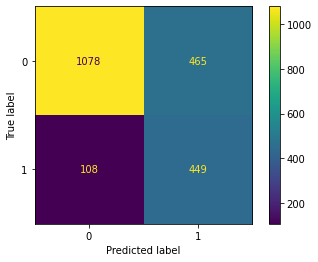

In [ ]:
predictions_v1 = first_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(Y_test, predictions_v1)
print(classification_report(Y_test, predictions_v1))
print(roc_auc_score(Y_test, first_model.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1543
           1       0.51      0.79      0.62       557

    accuracy                           0.74      2100
   macro avg       0.71      0.76      0.71      2100
weighted avg       0.80      0.74      0.76      2100

0.8345816108189996


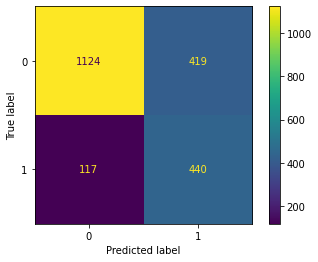

In [ ]:
predictions_v2 = retrain_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(Y_test, predictions_v2)
print(classification_report(Y_test, predictions_v2))
print(roc_auc_score(Y_test, retrain_model.predict_proba(X_test)[:, 1]))

In [ ]:
# Dataset para pronostico
url3 = "https://raw.githubusercontent.com/JulianTorrest/MINE-Ciencia-de-datos-Aplicada/main/Taller4/data/DataSet_Prediccion.json"
df3 = pd.read_json(url3)

In [ ]:
def get_final_pred_mv1(dataset):

    # Limpieza para ingerir el modelo
    clean_df3 = cleaning_1(dataset)

    # Realizar pronostico con el ultimo modelo
    df_predicted = pd.DataFrame(retrain_model.predict(clean_df3)).replace([0, 1],['No', 'Yes'])
    df_precited_proba = pd.DataFrame(retrain_model.predict_proba(clean_df3)[:, 1])
    df_predicted["proba"] = df_precited_proba
    df_predicted.columns =['Churn', 'Proba']

    return df_predicted

## Bono!!!

In [ ]:
def get_final_pred_mv0(dataset):

    # Limpieza para cargar el modelo
    clean_df3 = cleaning_1(dataset)

    # Pronostico con el primer modelo
    df_predicted = pd.DataFrame(first_model.predict(clean_df3)).replace([0, 1],['No', 'Yes'])
    df_precited_proba = pd.DataFrame(first_model.predict_proba(clean_df3)[:, 1])
    df_predicted["proba"] = df_precited_proba
    df_predicted.columns =['Churn', 'Proba']

    return df_predicted

In [ ]:
print(get_final_pred_mv1(df3).head(10))
print(get_final_pred_mv0(df3).head(10))

  Churn     Proba
0   Yes  0.773903
1   Yes  0.908847
2    No  0.412959
3    No  0.063696
4   Yes  0.545185
5   Yes  0.632094
6   Yes  0.709613
7   Yes  0.603133
8    No  0.020007
9   Yes  0.770729
  Churn     Proba
0   Yes  0.786923
1   Yes  0.881516
2   Yes  0.702191
3    No  0.118040
4   Yes  0.677070
5   Yes  0.779126
6   Yes  0.609935
7   Yes  0.734856
8    No  0.009930
9   Yes  0.813835
